In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.patches as mpatches
from scipy.stats import t
from itertools import combinations
from math import factorial
from scipy.stats import bootstrap

In [2]:
def stripper(x, length):
    dummy = []
    for i in x.strip().strip('[]').split():
        single = i.strip('\n')
        if single.isspace():
            continue
        if len(single) == 0:
            continue
        try:
            temp = float(single)
            dummy.append(temp)
        except:
            print(f"Warning: Couldn't convert {single} to float.")
    if len(dummy) != length:
        print(f"Warning: Only {len(dummy)} values were converted.")
    return dummy

In [3]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes two-sided paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = 2 * t.sf(np.abs(t_stat), df)  # two-sided t-test
    return t_stat, p_val

In [48]:
combis = ['RRP', 'RPP', 'RPR', 'RRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
#columns = ['RF_multiTime', 'RLR_multiTime', 'SVM_multiTime', 'RRP_multiTime', 'RPP_multiTime', 'RPR_muliTime', 'RRR_multiTime']
times = ['III14', 'C-1']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
}
result_dir="/Users/schmidtj/MalariaVaccineEfficacyPrediction/results"
#print(results)
for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
                for analysis_time in ['multiTime', 'singleTime']:
                    if method == 'multitaskSVM' and analysis_time =='multiTime':
                        for combination in combis:
                            ana_dir = f"{maindir}/{dataset}/{combination}/{analysis_time}/RNCV"
                            #print(ana_dir)
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                #print(temp)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

                    else:
                        if analysis_time == 'singleTime':
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                        
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)
                                
                                results[dataset][f'{time}_test'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold,f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]
                            
                            # index method muss noch die analysis zeit mit dazu bekommen!
                        else:
                        
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:

                                results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]
                            
                                


No results found for threshold=0.1, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=selective, analysis_time=singleTime.


In [40]:
results['whole']['III14_test_conf']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.8627500006, 0.923666667]","[0.8692589234670038, 0.9346666665999999]","[0.8631182419046688, 0.9331666663999999]","[0.7884166671285636, 0.8761492489586454]","[0.7677877505317023, 0.8547499998000001]","[0.8843308998136002, 0.9366666663580996]","[0.8740833335317026, 0.9489999995751872]","[0.8627500006, 0.923666667]","[0.8692589234670038, 0.9346666665999999]","[0.8631182419046688, 0.9331666663999999]"
0.2,"[0.8459452450082391, 0.9115833334]","[0.8781855803155689, 0.9494999998]","[0.8354977632078586, 0.9308333332000001]","[0.7443618653444221, 0.8470833335999999]","[0.8809999994585853, 0.9383333332]","[0.9081666661207186, 0.9554783676179895]","[0.884438435305658, 0.9485833328876696]","[0.8459452450082391, 0.9115833334]","[0.8781855803155689, 0.9494999998]","[0.8354977632078586, 0.9308333332000001]"
0.3,"[0.8207149862709601, 0.8909274402942029]","[0.843083333341219, 0.9208333333616489]","[0.7712499994970443, 0.8737597697419803]","[0.7702278985910246, 0.8529166667853668]","[0.807916667, 0.8764166668377996]","[0.9059166666082508, 0.9561666662449021]","[0.9090968079650098, 0.9563333331999999]","[0.8207149862709601, 0.8909274402942029]","[0.843083333341219, 0.9208333333616489]","[0.7712499994970443, 0.8737597697419803]"
0.4,"[0.8283472456977093, 0.8942500002665787]","[0.8478447378183819, 0.9164583331678275]","[0.8141666659999999, 0.8946666662]","[0.7693664066904059, 0.847416666150893]","[0.7457476647262266, 0.8400833334]","[0.8981666658, 0.9539166662317863]","[0.9150271183066575, 0.9568333328821113]","[0.8283472456977093, 0.8942500002665787]","[0.8478447378183819, 0.9164583331678275]","[0.8141666659999999, 0.8946666662]"
0.5,"[0.7901250003217896, 0.8660833338072675]","[0.840991804422538, 0.915]","[0.8113333332, 0.89491666687587]","[0.7517030137630114, 0.8354349084636215]","[0.780020709727728, 0.8650833337208355]","[0.8999999994928168, 0.951583333]","[0.9250833329448256, 0.9651329044480136]","[0.7901250003217896, 0.8660833338072675]","[0.840991804422538, 0.915]","[0.8113333332, 0.89491666687587]"
0.6,"[0.7769583332, 0.8565360568651033]","[0.8620764264301259, 0.9335416668000001]","[0.8177267572506838, 0.8999166664252778]","[0.7615833334754972, 0.8366219255646307]","[0.7846666666716776, 0.8672006649647289]","[0.9206666665072656, 0.963999999864361]","[0.8940833332, 0.9554999998]","[0.7769583332, 0.8565360568651033]","[0.8620764264301259, 0.9335416668000001]","[0.8177267572506838, 0.8999166664252778]"
0.7,"[0.7748834092561713, 0.8629041922961125]","[0.8510833328466284, 0.9200416664]","[0.823691573935765, 0.888333333658592]","[0.7953333336, 0.8690000000572949]","[0.841746121987436, 0.912499999737623]","[0.9155339821918079, 0.9607499996]","[0.9156666662, 0.9589166664]","[0.7748834092561713, 0.8629041922961125]","[0.8510833328466284, 0.9200416664]","[0.823691573935765, 0.888333333658592]"
0.8,"[0.733952418068885, 0.8149166660081139]","[0.8416249997999999, 0.9027916664]","[0.4569176224643486, 0.5969166666]","[0.7989166668045375, 0.8647499997207474]","[0.8036666663292218, 0.8738333327999999]","[0.922583333247347, 0.9653333330000001]","[0.8900293107147819, 0.9516666662]","[0.733952418068885, 0.8149166660081139]","[0.8416249997999999, 0.9027916664]","[0.4569176224643486, 0.5969166666]"
0.9,"[0.7383139522151084, 0.82225]","[0.7865088127154031, 0.8758333333709125]","[0.5415252325650698, 0.662738385098028]","[0.7993333334, 0.8613666509225629]","[0.8503333331999999, 0.9091666663999999]","[0.901416665984851, 0.9540833327999999]","[0.9086666666, 0.9583333329999999]","[0.7383139522151084, 0.82225]","[0.7865088127154031, 0.8758333333709125]","[0.5415252325650698, 0.662738385098028]"
1.0,"[0.7160416664, 0.8010036678511946]","[0.7487837738161733, 0.8487499995266076]","[0.569333333003804, 0.704557381953598]","[0.8042273399981824, 0.8794166662]","[0.8569407005125835, 0.9152572818702387]","[0.9143333333999999, 0.9573333330113525]","[0.8727499995085765, 0.9397136847632135]","[0.7160416

In [47]:
results['whole']['III14_test']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.875, 0.937...","[1.0, 0.75, 0.9375, 0.93333333, 0.93333333, 0....","[0.9375, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.875...","[1.0, 0.6875, 0.9375, 0.93333333, 0.8, 0.875, ...","[1.0, 0.5625, 0.875, 0.93333333, 0.93333333, 0...","[0.9375, 0.6875, 0.9375, 1.0, 1.0, 0.9375, 0.8...","[0.9375, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, ...","[1.0, 0.75, 0.9375, 0.93333333, 1.0, 0.6875, 0...","[0.875, 0.75, 0.9375, 1.0, 0.93333333, 0.875, ...","[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0..."
0.2,"[0.9375, 0.875, 0.8125, 1.0, 1.0, 0.9375, 0.93...","[1.0, 0.75, 0.9375, 1.0, 0.93333333, 0.9375, 1...","[0.9375, 0.75, 0.9375, 0.93333333, 1.0, 0.875,...","[0.8125, 0.5, 0.75, 0.93333333, 1.0, 0.875, 0....","[1.0, 0.875, 0.9375, 0.93333333, 1.0, 0.875, 0...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[0.96875, 0.6875, 0.84375, 0.93333333, 1.0, 0....","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.875, 0.9375, 1...","[0.875, 0.6875, 0.9375, 1.0, 1.0, 0.9375, 0.87..."
0.3,"[0.9375, 0.875, 0.8125, 1.0, 0.93333333, 1.0, ...","[1.0, 0.75, 0.9375, 1.0, 0.93333333, 0.9375, 1...","[0.9375, 0.6875, 0.875, 1.0, 1.0, 0.8125, 0.87...","[0.875, 0.6875, 0.75, 0.86666667, 0.93333333, ...","[0.5, 0.8125, 0.9375, 0.93333333, 0.86666667, ...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1.0...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1....","[1.0, 0.875, 0.75, 0.93333333, 0.8, 0.9375, 0....","[0.9375, 0.75, 0.9375, 0.93333333, 1.0, 0.875,...","[0.75, 0.6875, 0.8125, 0.93333333, 1.0, 0.8125..."
0.4,"[0.875, 0.8125, 0.875, 0.93333333, 1.0, 1.0, 0...","[0.9375, 0.75, 0.9375, 1.0, 0.93333333, 0.9375...","[0.8125, 0.75, 1.0, 0.93333333, 1.0, 0.8125, 0...","[0.75, 0.6875, 0.875, 0.93333333, 0.86666667, ...","[0.5, 0.875, 0.8125, 0.93333333, 1.0, 0.875, 0...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.9375, 0.93...","[0.875, 0.84375, 0.9375, 0.93333333, 0.8, 0.87...","[0.875, 0.6875, 0.9375, 1.0, 0.93333333, 0.812...","[0.875, 0.625, 0.9375, 0.93333333, 0.53333333,..."
0.5,"[0.8125, 0.875, 0.75, 1.0, 1.0, 0.9375, 0.8125...","[1.0, 0.8125, 0.9375, 1.0, 0.93333333, 0.9375,...","[1.0, 0.6875, 0.8125, 1.0, 0.86666667, 0.875, ...","[0.5625, 0.75, 0.8125, 0.93333333, 0.93333333,...","[0.75, 0.8125, 0.625, 0.93333333, 0.86666667, ...","[1.0, 0.75, 0.875, 1.0, 1.0, 0.875, 1.0, 1.0, ...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1....","[0.9375, 0.75, 0.875, 0.93333333, 0.8, 0.875, ...","[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.875, 0.937...","[0.875, 0.625, 0.75, 0.93333333, 1.0, 0.875, 0..."
0.6,"[0.875, 0.875, 0.875, 0.93333333, 1.0, 0.9375,...","[0.875, 0.8125, 0.9375, 0.86666667, 1.0, 0.937...","[1.0, 0.75, 0.875, 0.8, 1.0, 0.9375, 0.8125, 1...","[0.625, 0.75, 0.875, 0.93333333, 0.86666667, 0...","[0.75, 0.875, 0.875, 0.86666667, 0.86666667, 0...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[0.9375, 0.75, 0.8125, 0.86666667, 1.0, 1.0, 0...","[1.0, 0.75, 1.0, 0.86666667, 1.0, 0.9375, 0.87...","[1.0, 0.625, 0.9375, 0.86666667, 1.0, 0.8125, ..."
0.7,"[0.875, 0.84375, 0.8125, 0.93333333, 1.0, 1.0,...","[0.9375, 0.8125, 0.9375, 0.86666667, 1.0, 0.93...","[0.8125, 0.875, 0.75, 0.8, 0.86666667, 0.875, ...","[0.75, 0.6875, 0.8125, 1.0, 1.0, 0.6875, 0.875...","[0.75, 0.9375, 0.875, 0.93333333, 1.0, 0.625, ...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 0.875, ...","[0.875, 0.6875, 0.875, 0.93333333, 1.0, 1.0, 0...","[0.9375, 0.875, 0.9375, 0.93333333, 1.0, 0.937...","[0.9375, 0.8125, 0.75, 0.93333333, 0.86666667,..."
0.8,"[0.84375, 0.75, 0.8125, 1.0, 0.93333333, 1.0, ...","[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 0.9...","[0.75, 0.75, 0.75, 0.93333333, 0.86666667, 0.7...","[0.5625, 0.75, 0.8125, 1.0, 1.0, 0.75, 0.75, 1...","[0.625, 0.875, 0.6875, 0.86666667, 0.93333333,.

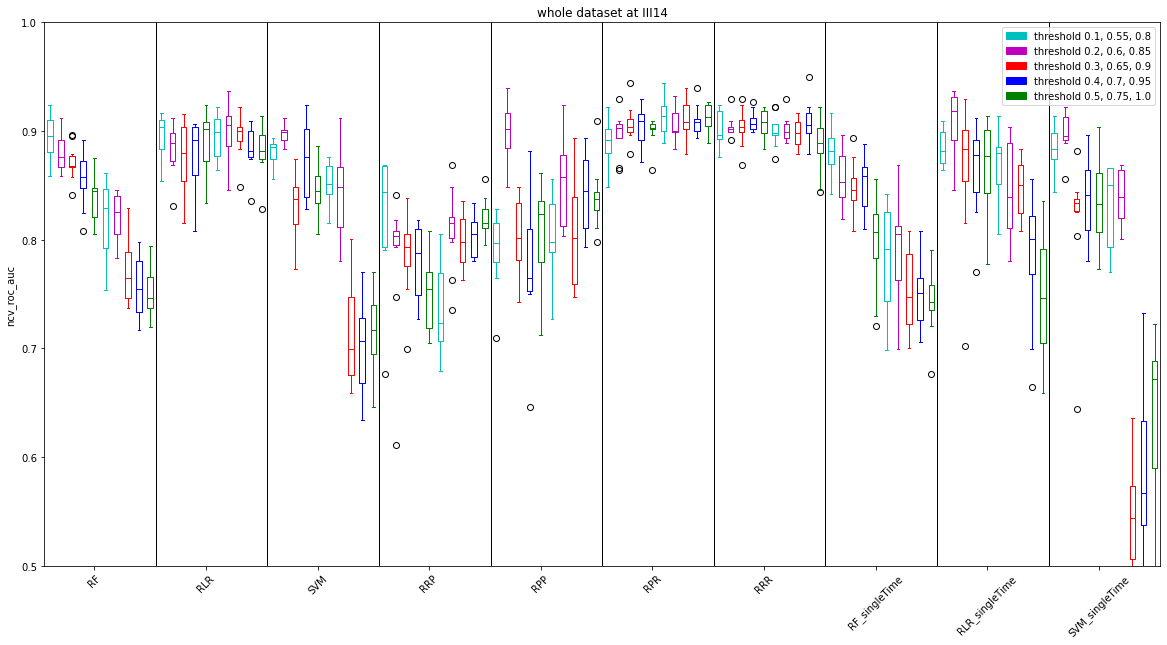

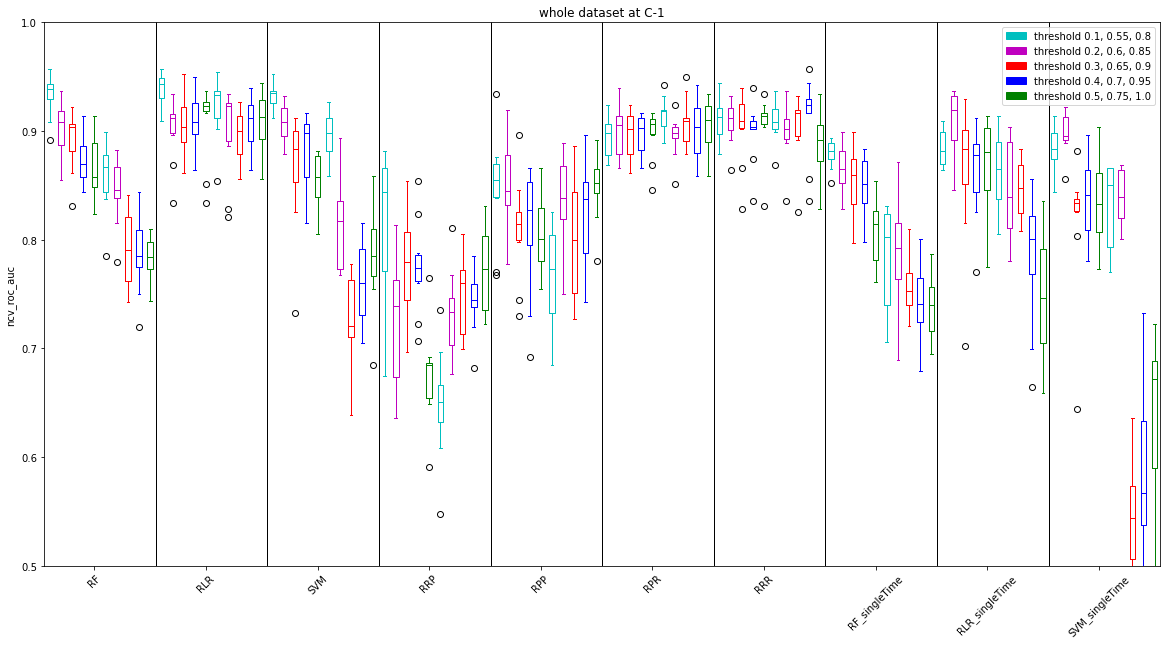

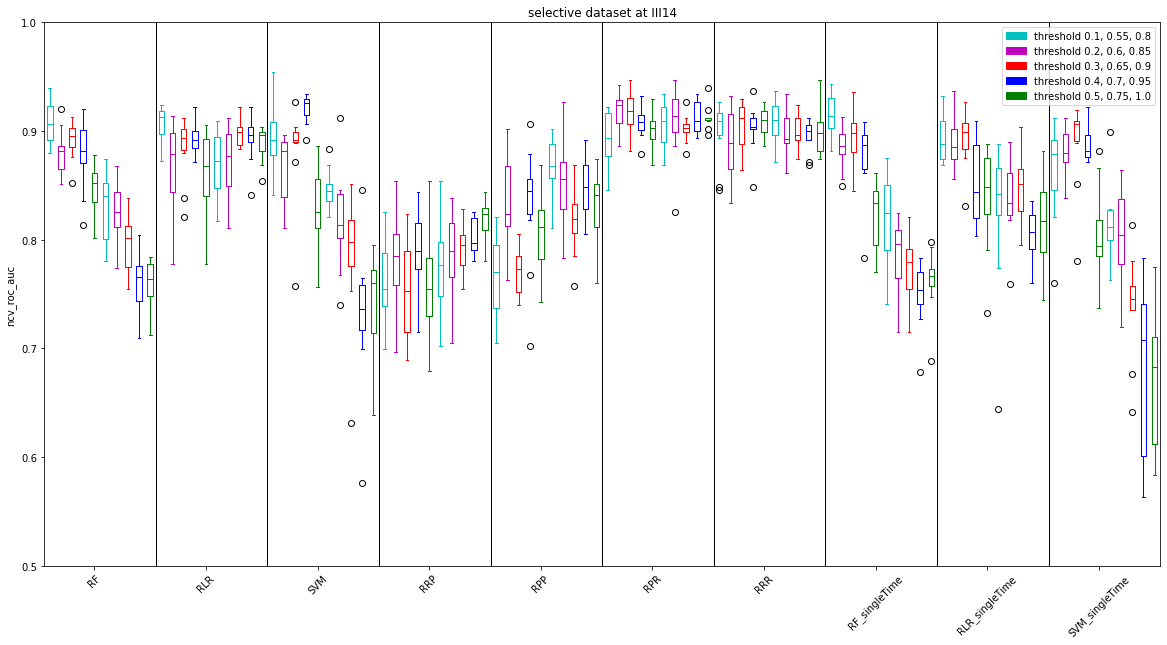

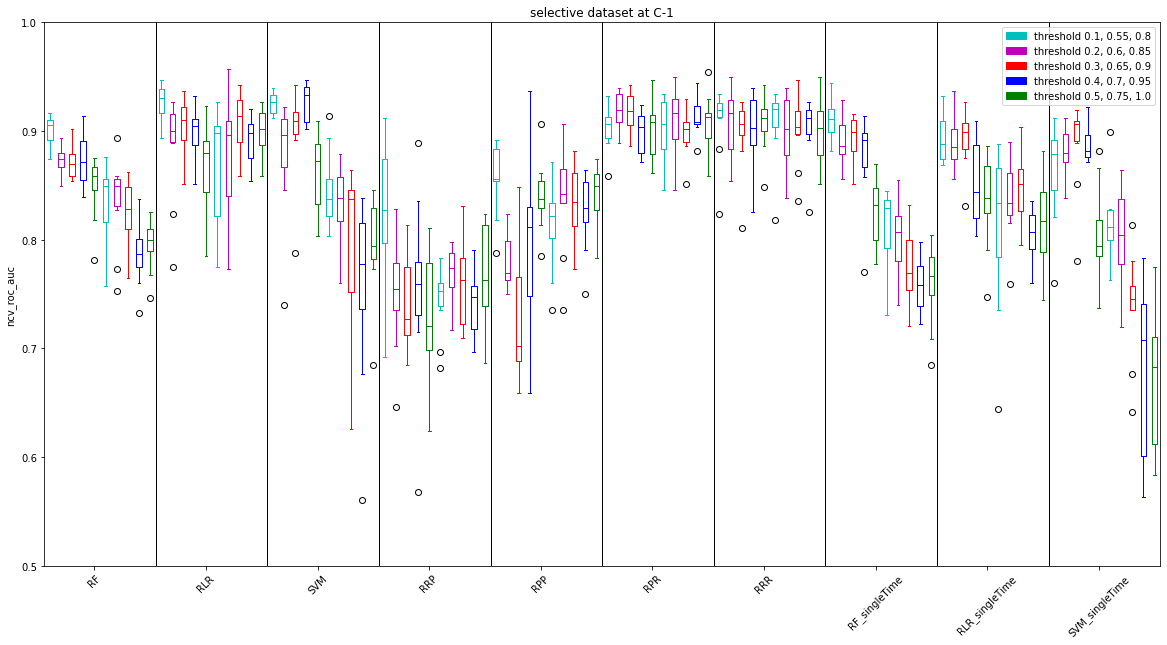

In [50]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.55, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6, 0.85')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.65, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7, 0.95')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 0.75, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0.5, 1))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("ncv_roc_auc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

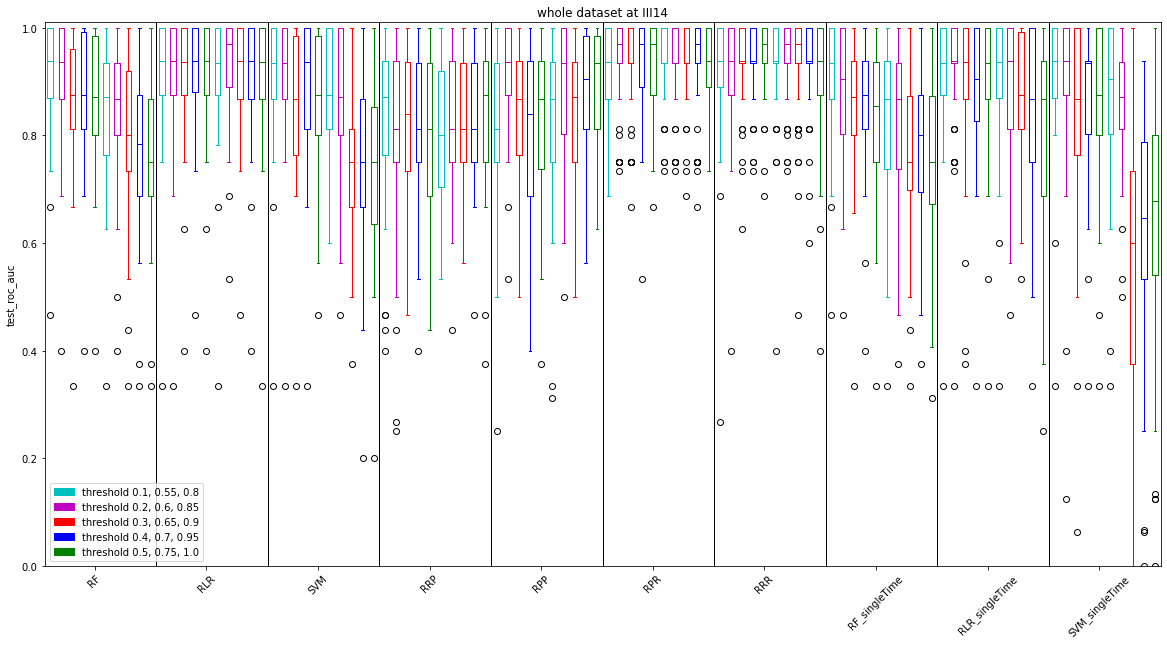

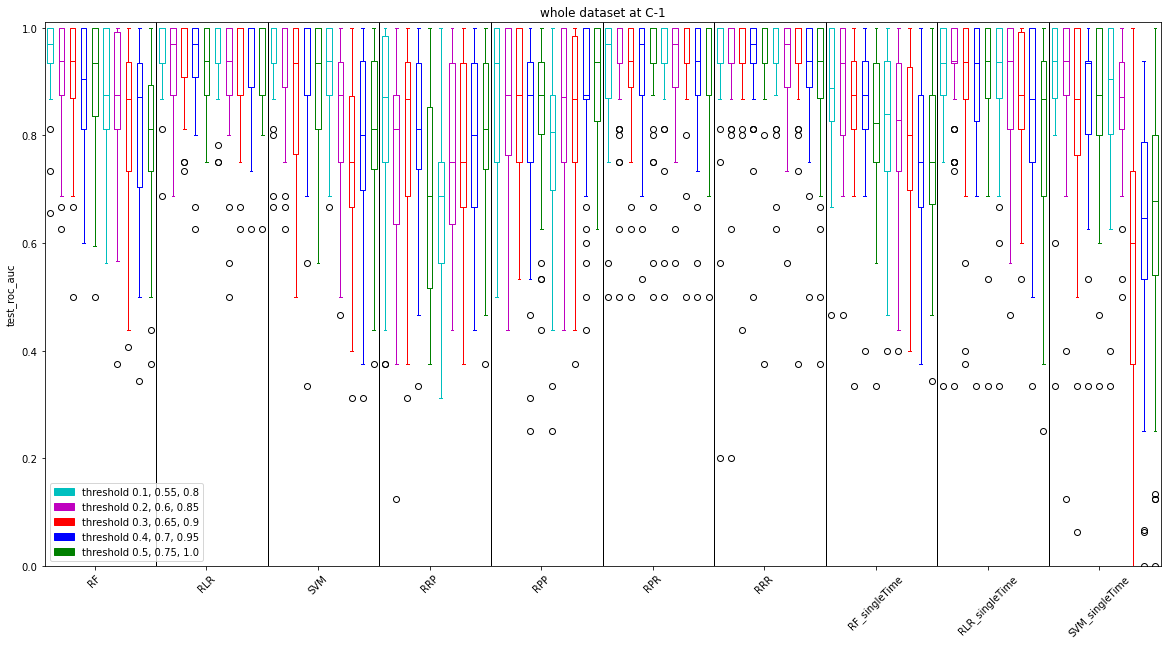

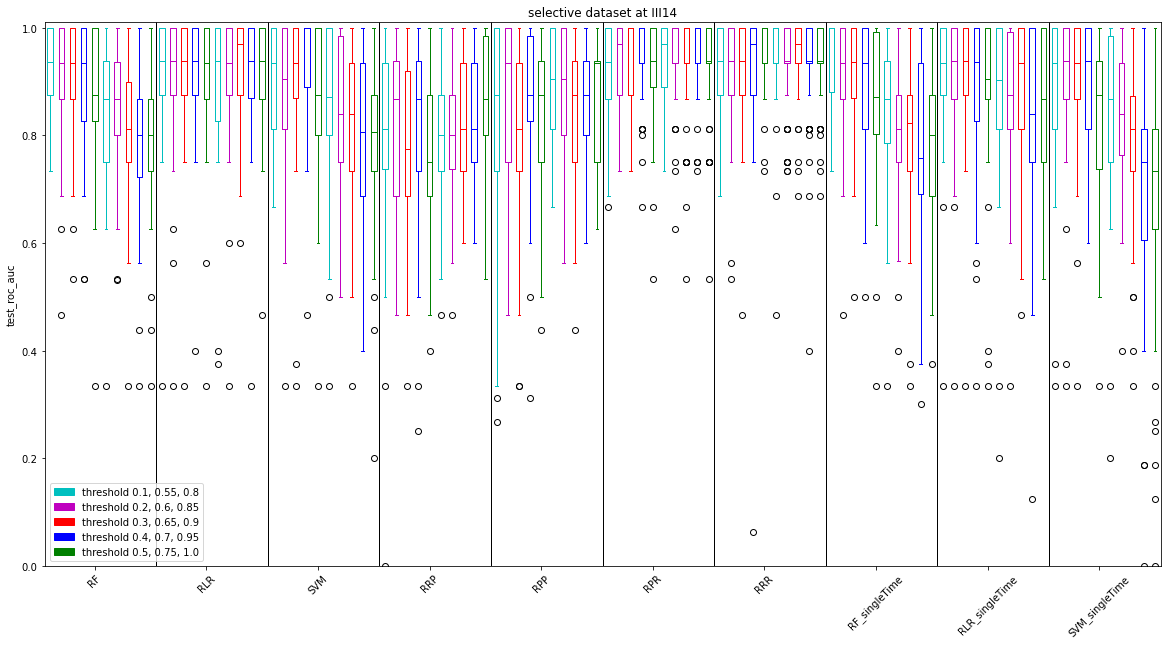

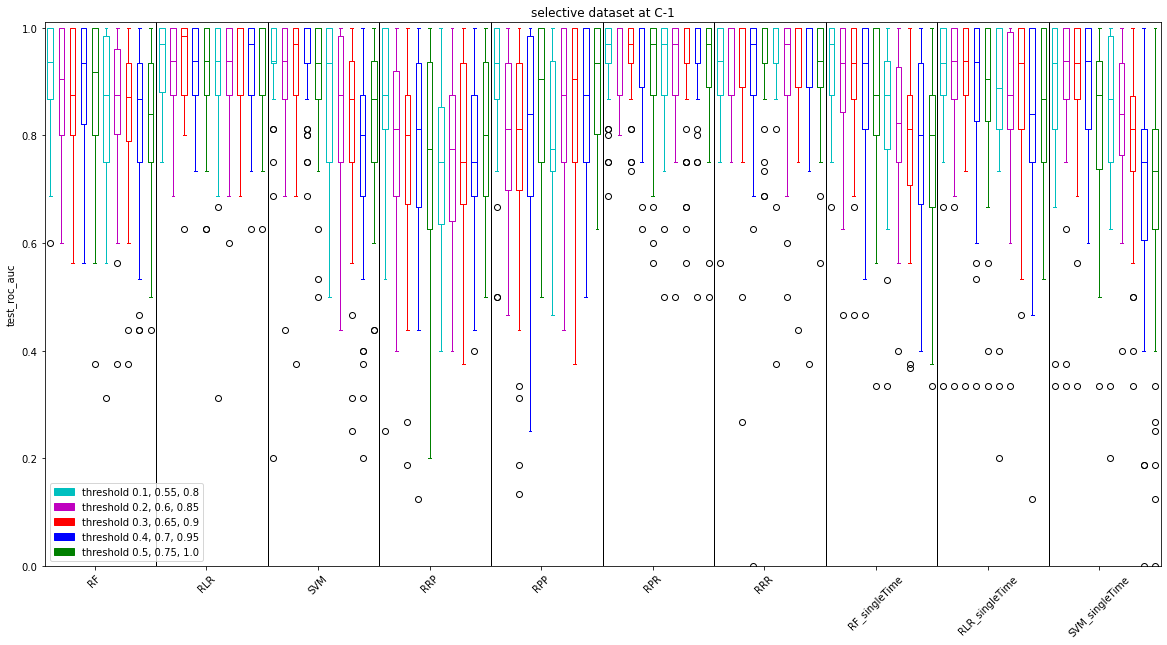

In [51]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_test'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.55, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6, 0.85')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.65, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7, 0.95')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 0.75, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1.01, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0, 1.01))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("test_roc_auc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [59]:
combis = ['RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'SRP', 'SPP', 'SPR', 'SRR']
times = ['III14', 'C-1', 'C28']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C28_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
    },
}
result_dir="/home/breuter/MalariaVaccineEfficacyPrediction/results"

for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
            if method == 'multitaskSVM':
                for combination in combis:
                    ana_dir = f"{maindir}/{dataset}/{combination}/RNCV"
                    fn = os.path.join(ana_dir, "collected_key_results.tsv")
                    try:
                        temp =  pd.read_csv(fn, sep='\t', index_col=0)
                    except:
                        print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}.")
                        continue
                    for time in times:

                        results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10)

                        results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50)

                        results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_ncv_mcc'].values[0]

                        results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_test_mcc'].values[0]

                        ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                        results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                        ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                        results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

            else:
                ana_dir = f"{maindir}/{dataset}/RNCV"
                fn = os.path.join(ana_dir, "collected_key_results.tsv")
                try:
                    temp =  pd.read_csv(fn, sep='\t', index_col=0)
                except:
                    print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}.")
                    continue
                for time in times:

                    results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10)

                    results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50)

                    results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_ncv_mcc'].values[0]

                    results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_test_mcc'].values[0]

                    ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                    results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                    ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                    results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]


No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=RRP.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=RPP.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=RPR.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=RRR.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=SRP.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=SPP.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=SPR.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, combination=SRR.


In [61]:
results['whole']['III14_test_conf']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,SRP,SPP,SPR,SRR
0.10,"[0.6785221688073301, 0.7941438137161194]","[0.6041249255130015, 0.7435691483984332]","[0.6533571368939052, 0.7815001923008535]","[0.6120697888831546, 0.7449881230237325]","[0.7040905794994914, 0.8383135338165336]","[0.667557194636588, 0.7788790431239208]","[0.6363181732042187, 0.7592043593077686]","[0.5333866930791934, 0.6747636413977389]","[0.6784323537625245, 0.8149715800286821]","[0.6956782205163597, 0.8005265683170486]","[0.6111433393135813, 0.7395317245034445]"
0.20,"[0.6427264659533709, 0.7558619328473798]","[0.6348321937315253, 0.7597525132958082]","[0.6635839043444043, 0.7840749817662411]","[0.43602233113300054, 0.5868282369069991]","[0.44278785186474046, 0.6179298262560635]","[0.6228191568727179, 0.7411561056282638]","[0.6437102697919945, 0.7736732392055203]","[0.38706609727821767, 0.5491034769319744]","[0.4925505800789016, 0.6410791605186953]","[0.6741989815430495, 0.7878480609870838]","[0.6045702108760757, 0.73693059016952]"
0.30,"[0.6368711282334683, 0.7577937140906661]","[0.6371164216877027, 0.7684399778034671]","[0.6595237912994065, 0.7829468124275167]","[0.5127786487919997, 0.6435735410986516]","[0.49495625671701365, 0.640812369695413]","[0.6349091092678794, 0.7498221030785629]","[0.6779047280318158, 0.7859377194522841]","[0.48310895589100933, 0.6250699305894903]","[0.49301057034841655, 0.6189398112630259]","[0.6611582577671765, 0.7764673713151288]","[0.6595080534871658, 0.7850509445001865]"
0.40,"[0.6387684202172677, 0.7459508374263032]","[0.6615141098659177, 0.785041552746368]","[0.5900335342703602, 0.7246335014542754]","[0.35479378276914136, 0.512898647483526]","[0.4817672559090229, 0.6539137140226634]","[0.6577234018707632, 0.7708716520585273]","[0.6654203553727365, 0.7893544085905196]","[0.3466584384018867, 0.4993359722869522]","[0.4414152968197676, 0.5939002954279152]","[0.6627491028624181, 0.7804098880841532]","[0.6661290765216467, 0.7878878370136329]"
0.50,"[0.6672054040051685, 0.7826572738015417]","[0.6741922509417548, 0.7969290967741097]","[0.6223319032477365, 0.7544560293079453]","[0.28222064624117504, 0.4424606982447459]","[0.41841719359283475, 0.5634387743256848]","[0.6367633302914603, 0.7520500167699837]","[0.6727612615277632, 0.7967409526144417]","[0.28697032687598, 0.465361330064268]","[0.4023346688067318, 0.5476515014360114]","[0.6262813154634403, 0.7527837946568288]","[0.6220030882935008, 0.7627548908391043]"
0.55,"[0.6562528833943835, 0.7747914934815346]","[0.6871475523467195, 0.8010159000625019]","[0.6330721876045812, 0.7612282536860461]","[0.3391004849979854, 0.5180220742040593]","[0.4263027751427254, 0.5947611480486078]","[0.6530368996385327, 0.7712954421208801]","[0.7499945024505099, 0.852017097151051]","[0.3642289234983784, 0.5357518621152585]","[0.39984411063030084, 0.5460025545980193]","[0.6401162885867806, 0.7596195858760982]","[0.7300546485234635, 0.8300409283532117]"
0.60,"[0.6209215964368643, 0.7418912601110671]","[0.6697363049002752, 0.7926094691306833]","[0.5052145700796435, 0.6464216297361862]","[0.2743430694234567, 0.4557520340060713]","[0.4575975021945717, 0.6162203399714886]","[0.6603076558872863, 0.7786959162940595]","[0.6364836140998498, 0.765648966589107]","[0.30793697878104026, 0.5039379693817285]","[0.4204864460057366, 0.5476908718026676]","[0.6643822226527288, 0.7885042898176796]","[0.6534091601468873, 0.7695526377852419]"
0.65,"[0.652375478408022, 0.7717948234561969]","[0.6625270381500284, 0.7918888434515938]","[0.5668811160015854, 0.7109355108216568]","[0.33742473128334255, 0.4621435389807167]","[0.530947439494727, 0.6692456875374571]","[0.6369226538261442, 0.7782023945400522]","[0.6571816074226856, 0.7816414828322555]","[0.29622751223919525, 0.45084879166984754]","[0.48927511626898357, 0.6258739591512041]","[0.6782613428311889, 0.7926617420922952]","[0.6407438014853879, 0.7791795020290238]"
0.70,"[0.6154889729394327, 0.7404329884638042]","[0.6665922473447937, 0.7766793476136179]","[0.42294027468524287, 0.54929350336569

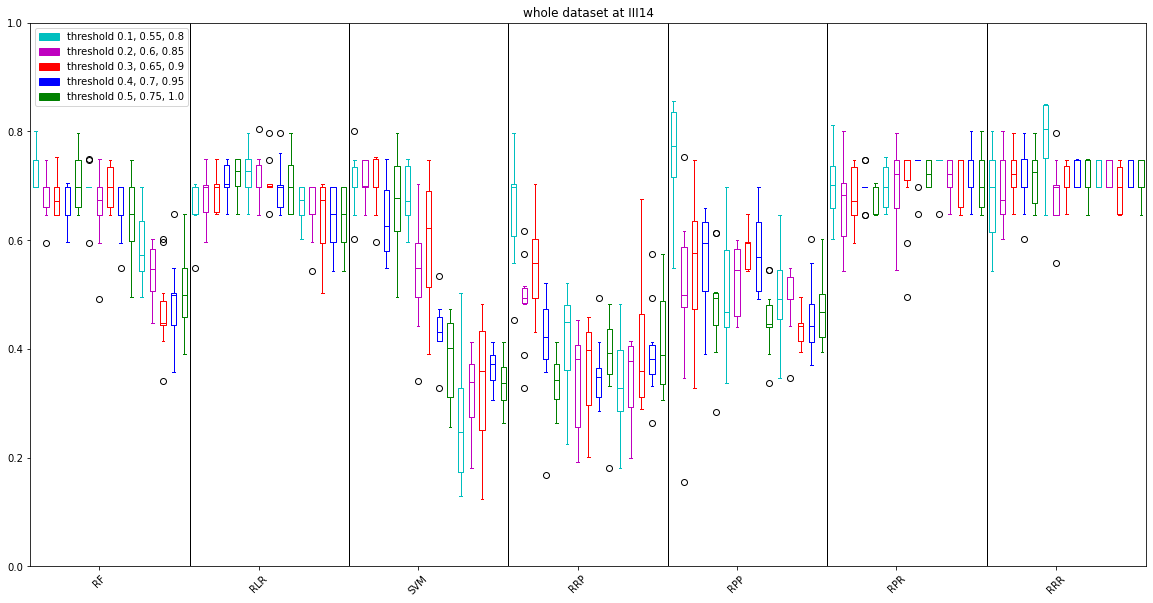

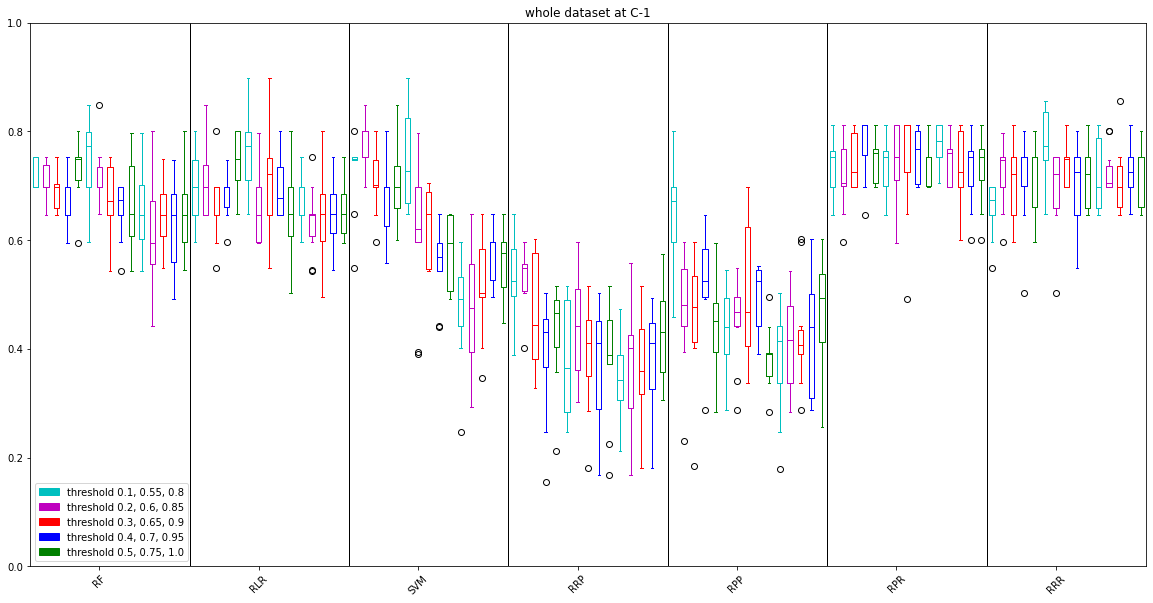

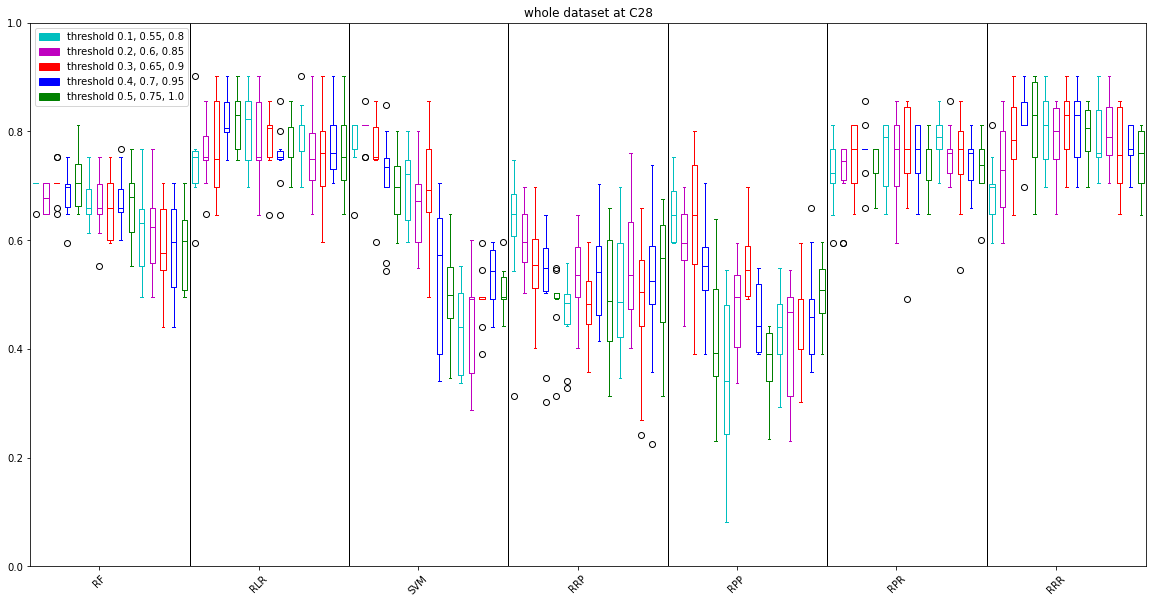

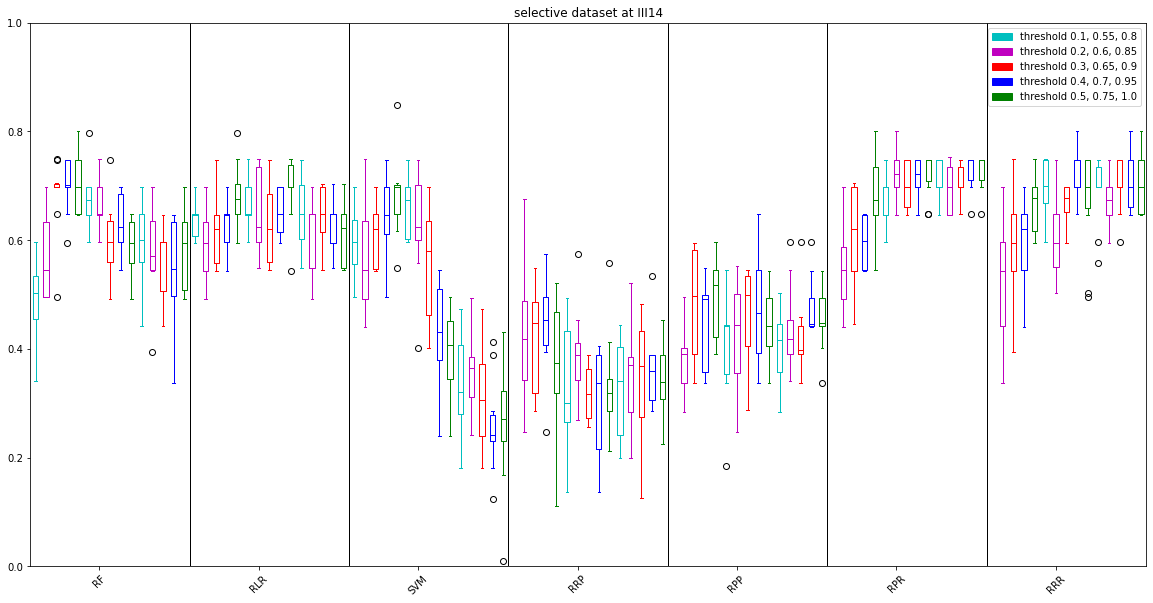

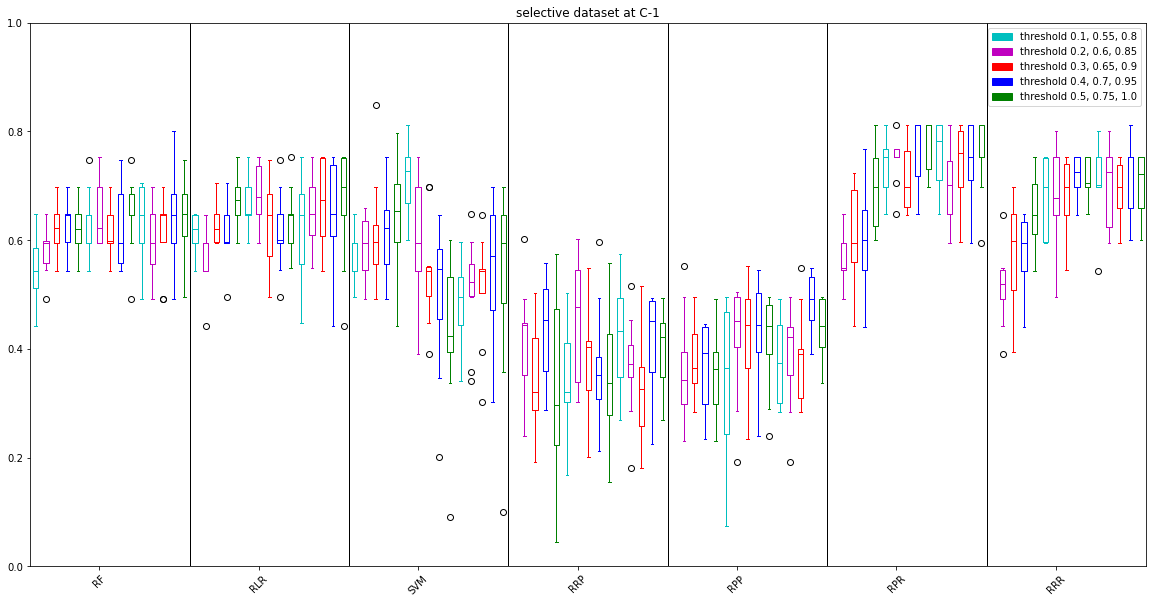

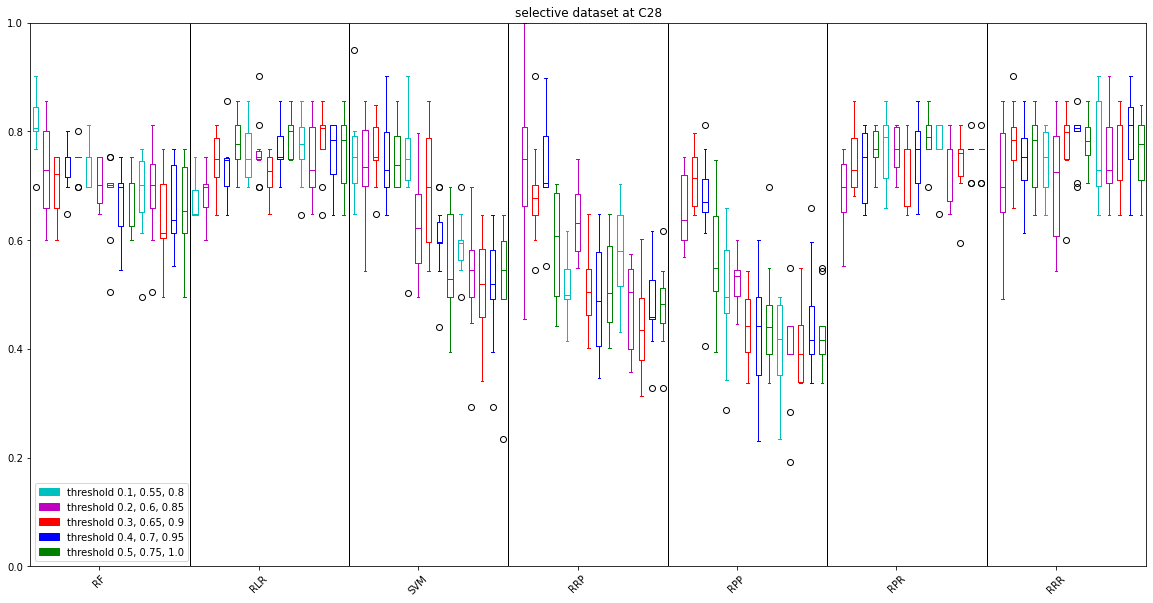

In [71]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.55, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6, 0.85')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.65, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7, 0.95')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 0.75, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0, 1))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

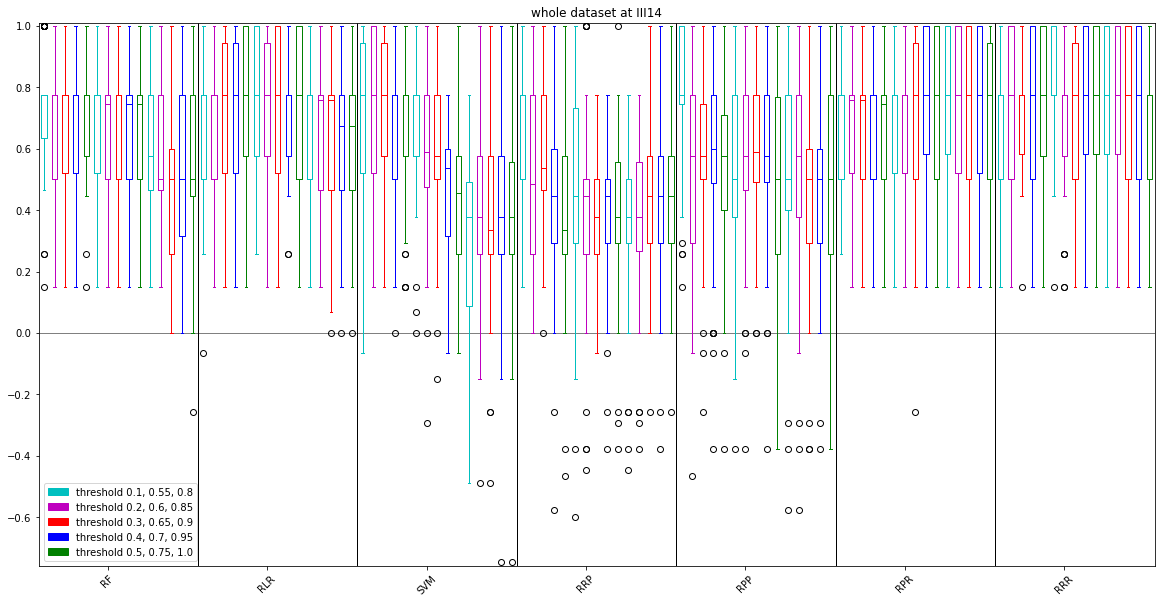

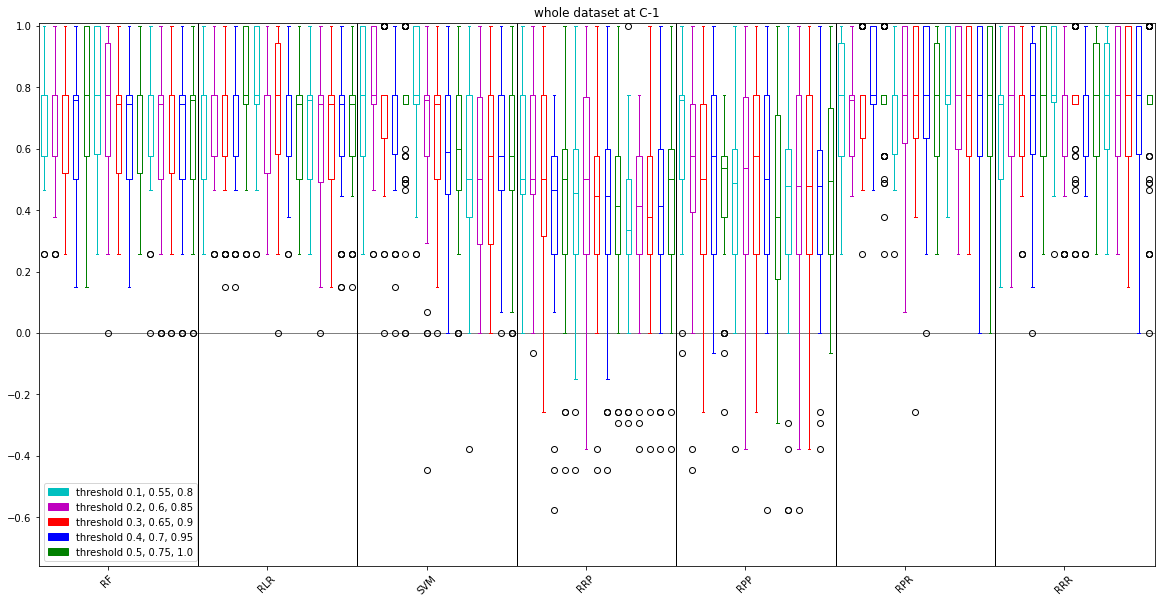

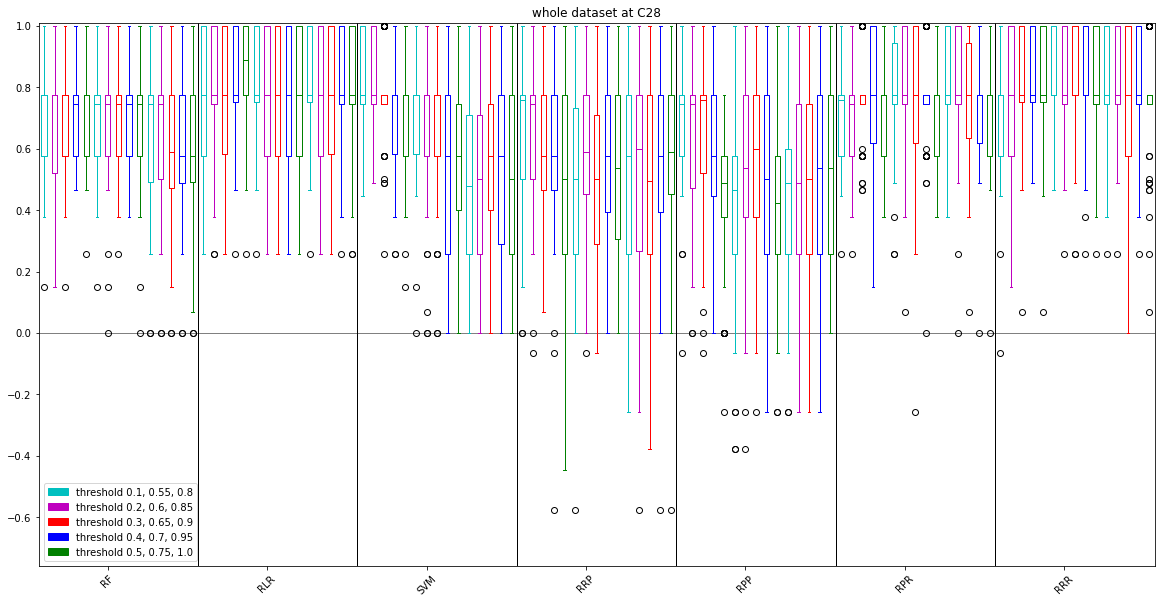

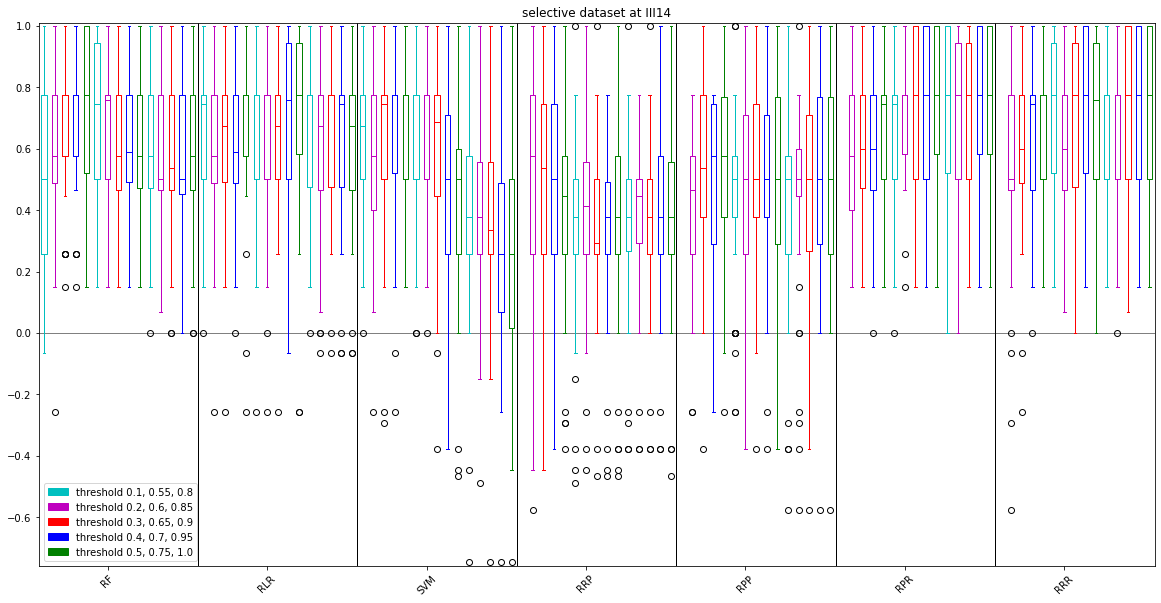

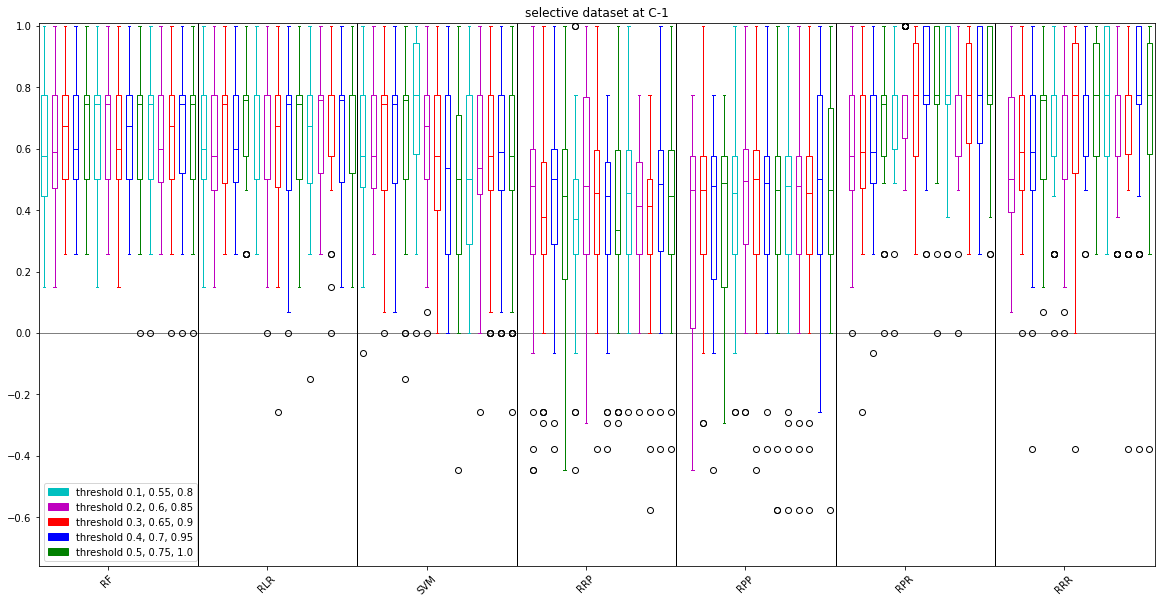

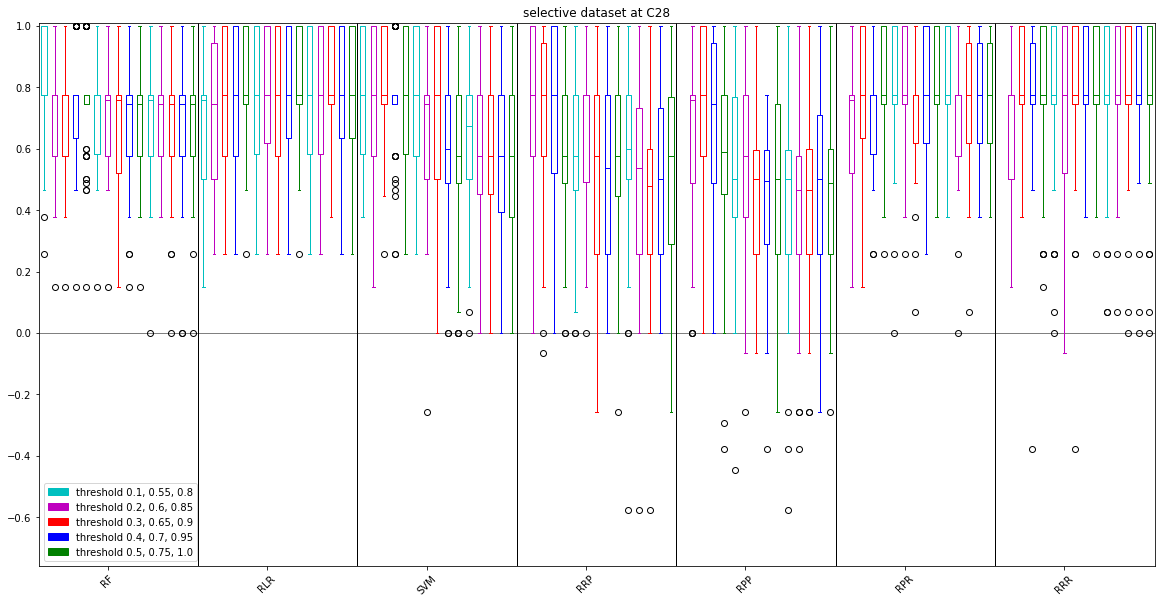

In [75]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        plt.hlines(0, 0.5, len(thresholds) * len(columns) + 0.5, color='gray', linewidth=1)
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_test'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.55, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6, 0.85')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.65, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7, 0.95')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 0.75, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, -0.76, 1.01, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((-0.76, 1.01))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [6]:
# corrected

n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.158        0.511      0.330
1     RPR     RRP   3.101  0.019       0.001        0.997      0.002
2     RPR     RPP   2.384  0.126       0.006        0.982      0.013
3     RRR     RRP   2.928  0.031       0.001        0.995      0.004
4     RRR     RPP   2.047  0.276       0.014        0.962      0.024
5     RRP     RPP  -0.479  1.000       0.595        0.239      0.166

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.158        0.511      0.330
1     RPR     RRP   3.101  0.019       0.001        0.997      0.002
2     RPR     RPP   2.384  0.126       0.006        0.982      0.013
3     RRR     RRP   2.928  0.031       0.001        0.995      0.004
4     RRR     RPP   2.047  0.276       0.014        0.962      0.024
5     RRP     RPP  -0.479  1.000       0.595        0.239      0.166

whole C28


In [7]:
# uncorrected bayesian

n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=np.std(differences, ddof=1)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.373        0.504      0.123
1     RPR     RRP   3.101  0.019       0.143        0.817      0.040
2     RPR     RPP   2.384  0.126       0.202        0.753      0.045
3     RRR     RRP   2.928  0.031       0.155        0.802      0.044
4     RRR     RPP   2.047  0.276       0.234        0.719      0.047
5     RRP     RPP  -0.479  1.000       0.531        0.410      0.060

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR     RRR   0.520  1.000       0.373        0.504      0.123
1     RPR     RRP   3.101  0.019       0.143        0.817      0.040
2     RPR     RPP   2.384  0.126       0.202        0.753      0.045
3     RRR     RRP   2.928  0.031       0.155        0.802      0.044
4     RRR     RPP   2.047  0.276       0.234        0.719      0.047
5     RRP     RPP  -0.479  1.000       0.531        0.410      0.060

whole C28


In [8]:
# corrected

n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C28


In [9]:
# uncorrected bayesian

n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=np.std(differences, ddof=1)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.110        0.861      0.029
1     RPR     RLR   1.350  1.000       0.222        0.734      0.044
2     RPR     SVM   3.154  0.016       0.050        0.942      0.008
3      RF     RLR  -0.936  1.000       0.658        0.288      0.054
4      RF     SVM   1.700  0.572       0.182        0.800      0.017
5     RLR     SVM   2.079  0.257       0.136        0.850      0.014

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.110        0.861      0.029
1     RPR     RLR   1.350  1.000       0.222        0.734      0.044
2     RPR     SVM   3.154  0.016       0.050        0.942      0.008
3      RF     RLR  -0.936  1.000       0.658        0.288      0.054
4      RF     SVM   1.700  0.572       0.182        0.800      0.017
5     RLR     SVM   2.079  0.257       0.136        0.850      0.014

whole C28
